## Report 07/11/2022


Here we use data from all countries with titles and abstracts ready available in English. These are: Australia, Canada, 'Europe', India, Ireland, New Zealand, UK and USA. For these analysis, we also excluded the medical data (e.g. MRC, NIH...), leaving us with a total of 2,985,010 documents (titles and abstracts) of raw data and 2,827,560 documents of processed data.


In [13]:
import os
import pandas as pd
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [14]:
# read in all raw data

# path to the file with all paths to files
paths = "/home/flavia/Projects/Funding-Landscape/code/supporting-files/directories-path/titles-abstracts-dir-STEM.txt"

# read file with all paths to files
paths_df = pd.read_csv(paths, names = ["fn","FundingBody"], delimiter= " ")

# create empty lists to store number of documents and country name
n_docs = []
country = []

# for line in file with paths to files
for fn in paths_df["fn"]:
    # count the number of lines in each file (each line is a separate document)
    n_docs.append(sum(1 for line in open(fn)))
    # get the name of the country (index 7/position 6) from the file path (line)
    country.append(fn.split("/")[7])

# store number of lines and country name 
paths_df["n_docs"] = n_docs
paths_df["country"] = country

paths_df.agg({"n_docs":"sum"})

n_docs    2985010
dtype: int64

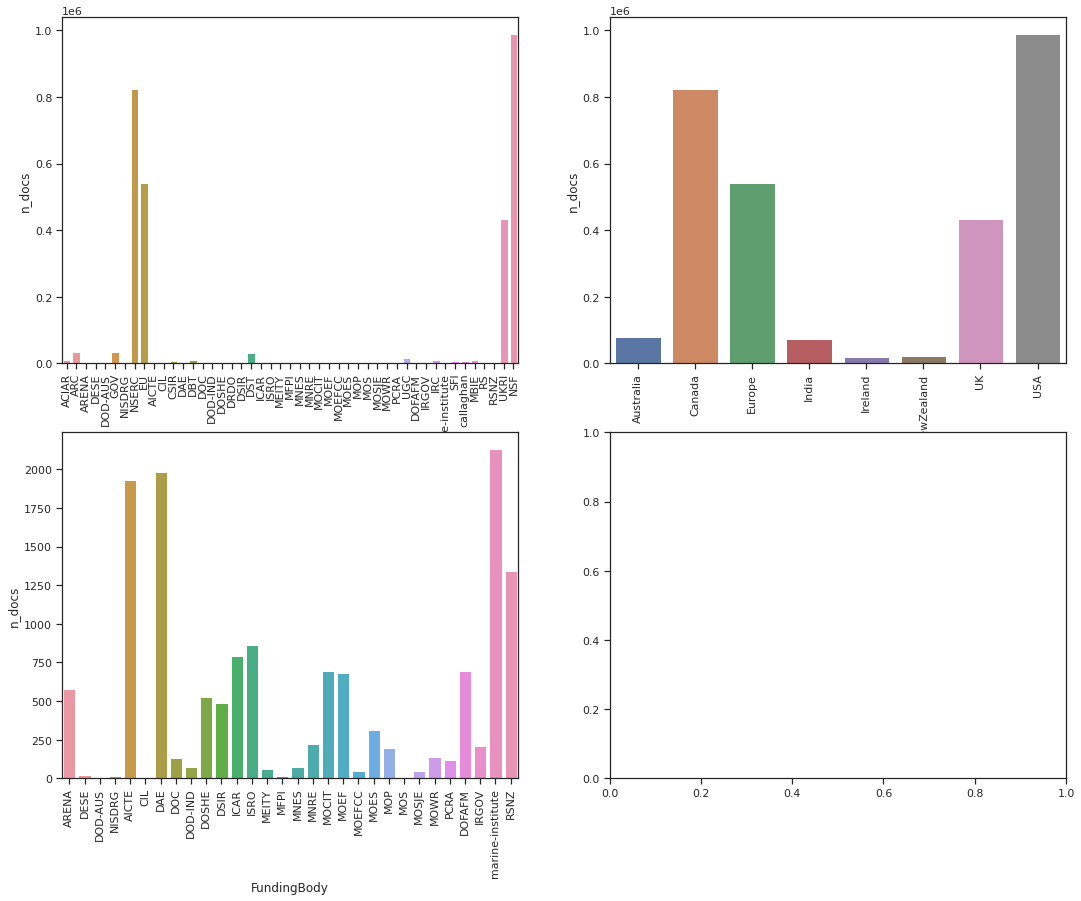

In [15]:
# plot number of documents per research council and funding body
sns.set(rc={'figure.figsize':(18,14)}) 
sns.set_theme(style="ticks")

fig, axs = plt.subplots(ncols=2, nrows=2)

sns.barplot(data = paths_df, x = "FundingBody", y = "n_docs", ax=axs[0,0]) 
axs[0,0].tick_params(axis='x', labelrotation=90)

paths_df_filtered = pd.DataFrame(paths_df).query("n_docs < 2500")
sns.barplot(data = paths_df_filtered, x = "FundingBody", y = "n_docs", ax=axs[1,0]) 
axs[1,0].tick_params(axis='x', labelrotation=90)

df_agg = paths_df.groupby("country").agg({"n_docs":"sum"}).reset_index()
sns.barplot(data = df_agg, x = "country", y = "n_docs", ax=axs[0,1]) 
axs[0,1].tick_params(axis='x', labelrotation=90)


#### Total number of documents in raw data
2,985,010

#### Total number of documents in processed data
2,827,560

Due to the preprocessing, data was reduced from 2,985,010 to 2,827,560 documents (titles-abstracts). Documents were removed if they contained less than 5 tokens after removing stop-words. The reason for this is that short text data adds bias in identifying topics from text. The longer the text, the more accurate to identify its contex. 

In [16]:
processed_text = pd.read_csv("/home/flavia/Projects/Funding-Landscape/clean-data/fine-scale/STEM/titles-abstracts-tokenized-filtered.csv", delimiter=" ", header=None,
names=["ProjectId", "FundingBody", "Tokens"])
processed_text.size

2827560

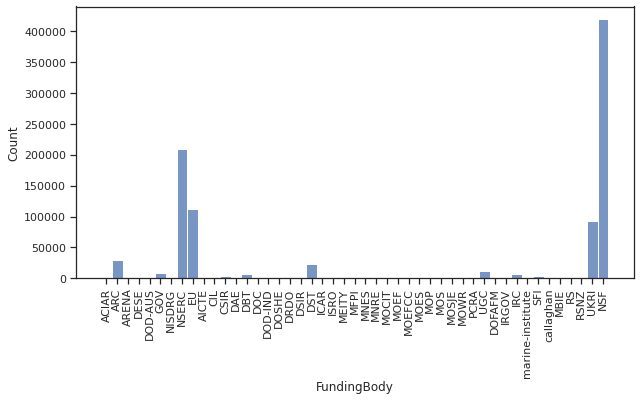

In [17]:
sns.set(rc={'figure.figsize':(10,5)}) 
sns.set_theme(style="ticks")

sns.histplot(data=processed_text, x="FundingBody").tick_params(axis='x', labelrotation=90)

Below we calculate the average coherence scores for a given topic model using the individual topic coherence from the diagnostic files created by Mallet when fitting the LDA model for each number of topics. We stored values in the previously created dictionary.

In [18]:
base_path = '../results/fine-scale/mallet-models/STEM/'

topic_paths = os.listdir(base_path)

data = []

# for folders (dif topic models) in path
for t in topic_paths:

    # use folders within not txt files in this dir
    if not t.endswith(".txt"):
        # get the path to a speficic model with t number of topics
        rep_path = os.listdir(base_path + t)
        
        ## get number of replicates (reps) for model with t number of topics
        # get the number of topics
        topics = (t.split("-")[0])
        # get the replicates for each topic
        reps = set([(x.split("-")[0]) for x in rep_path])
        
        #get perplexity for topic t
        for r in reps:
            ## get perplexity
            # get file name
            LP_fn = "-".join([r,topics,"topics-log-probability"])
            ## get perplexity from file LP_fn
            LP = sum([float(x) for x in open("/".join([base_path,t,LP_fn]))])

            # get path to file with number of tokens per document
            doc_length_path = base_path + r + "-doc-lengths.txt"

            # get total number of tokens per document
            N_words = sum([float(x) for x in open(doc_length_path)])

            # calculate perplexity per model (-perplexity per document/number of tokens in each document) 
            perp = np.exp(-LP / N_words)

            ## get topic diagnostics
            # get path to diagnostics file
            fn = "-".join([r,topics,"topics-diagnostics.xml"])
            # parse xml format
            tree = ET.parse("/".join([base_path,t,fn]))
            root = tree.getroot()

            # get coherence values from file
            # c = [float(child.attrib['coherence']) for child in root]
            
            #get diagnostics
            diag_df = pd.DataFrame([c.attrib for c in root])
            diag_df["n_topics"] = int(topics)
            diag_df["rep"] = int(r)
            diag_df["perplexity"] = perp

            data.append(diag_df)

            # # create dataframe with coherence, model, replicates, perplexity
            # for i in c:
            #     data["coherence"].append(i)
            #     data["n_topics"].append(int(topics))
            #     data["rep"].append(int(r))
            #     data["perplexity"].append(perp)

data = pd.concat(data).apply(pd.to_numeric)


In [19]:
data

,id,tokens,document_entropy,word-length,coherence,uniform_dist,corpus_dist,eff_num_words,token-doc-diff,rank_1_docs,allocation_ratio,allocation_count,exclusivity,n_topics,rep,perplexity
0,0,361695.0,9.8750,7.85,-391.2833,5.5799,1.7508,30.1250,0.0148,0.1178,0.0319,0.1043,0.0754,175,1,1272.952013
1,1,290811.0,9.6694,8.20,-353.9351,5.0493,2.1061,78.3980,0.0055,0.1598,0.0424,0.1480,0.1597,175,1,1272.952013
2,2,420802.0,9.1298,7.65,-266.5630,4.8097,1.5862,99.1509,0.0136,0.2563,0.1126,0.2571,0.1125,175,1,1272.952013
3,3,273505.0,8.8490,7.20,-292.5847,4.3695,1.9327,202.7692,0.0070,0.2962,0.1796,0.2896,0.1802,175,1,1272.952013
4,4,218056.0,8.9238,7.10,-356.1122,5.0096,2.2281,56.9127,0.0094,0.2175,0.1457,0.2314,0.2758,175,1,1272.952013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,70,797335.0,9.9043,7.10,-340.3556,4.5708,1.7313,36.0298,0.0381,0.2546,0.1676,0.3023,0.1457,75,3,1393.786941
71,71,527026.0,9.6175,7.05,-355.0993,4.3935,1.6387,141.0688,0.0109,0.2359,0.1434,0.2638,0.2197,75,3,1393.786941
72,72,776195.0,9.9711,7.55,-338.5018,4.4377,1.6403,136.8112,0.0068,0.2656,0.1611,0.3042,0.2688,75,3,1393.786941
73,73,1133266.0,10.9429,7.10,-331.6739,5.2157,1.3678,48.1314,0.0104,0.0652,0.0129,0.0851,0.1349,75,3,1393.786941


### Plotting coherence vs number of topics and perplexity vs number of topics

To interpret coherence: we are looking for a large number of coherence, or a big increase from the previous value to the next;

To interpret perplexitty: we are looking for the lowest number. 

Coherence and perplexity are two measures of model performance, but they measure two separate types of performance. Coherence measures the ability of the model finding topics that are the closest to human interpretability. While perplexity measures the ability of the model to classify unseen data with a trained model. 

We used 70% of the data for training and 30% for validation.

<AxesSubplot:xlabel='n_topics', ylabel='perplexity'>

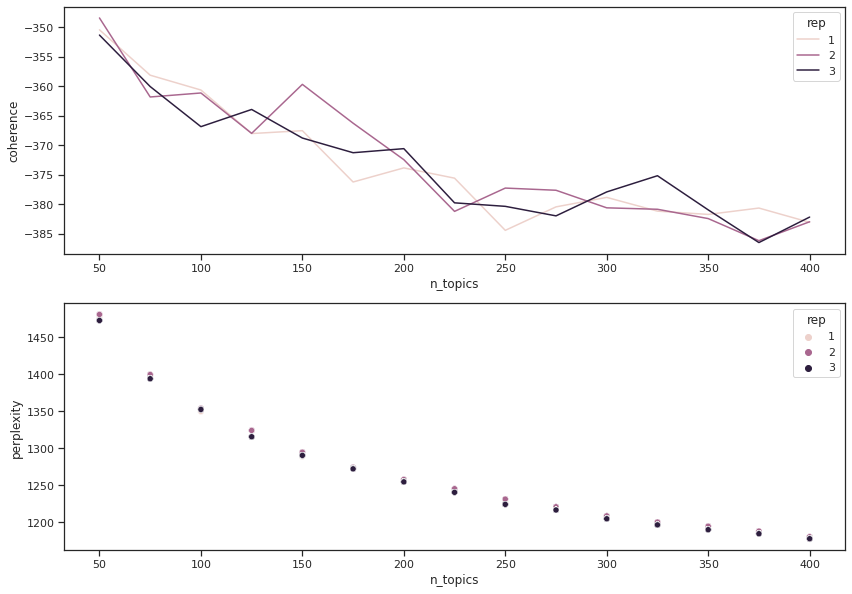

In [20]:
# plot settings
sns.set(rc={'figure.figsize':(14,10)}) 
sns.set_theme(style="ticks")
fig, axs = plt.subplots(ncols=1, nrows=2)

# turn dict into df
df = pd.DataFrame(data)

plot_df = df.groupby(["rep", "n_topics"]).agg({"coherence":"mean"}).reset_index()
# plot_df
# Plot 
sns.lineplot(x="n_topics", y="coherence", hue = "rep",  data=plot_df, ax = axs[0])
# .axhline(-950, linestyle ="--")

sns.scatterplot(x="n_topics", y="perplexity", hue = "rep",  data=df, ax = axs[1])

<AxesSubplot:xlabel='n_topics', ylabel='perplexity'>

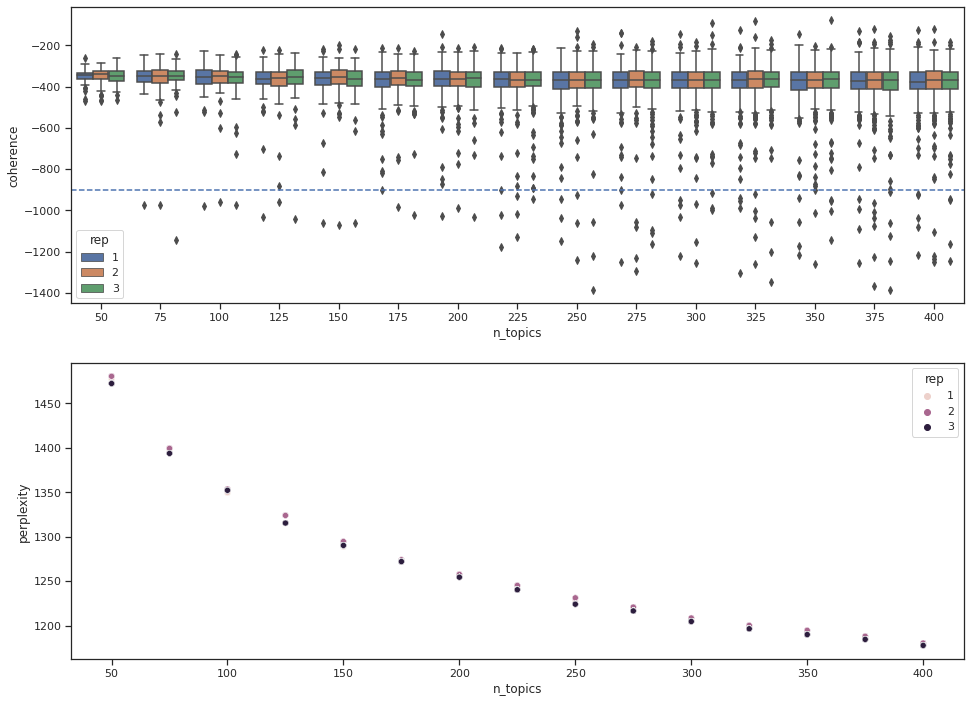

In [21]:
# plot settings
sns.set(rc={'figure.figsize':(16,12)}) 
sns.set_theme(style="ticks")
fig, axs = plt.subplots(ncols=1, nrows=2)

# turn dict into df
df = pd.DataFrame(data)

sns.boxplot(x="n_topics", y="coherence", hue = "rep",  data=df, ax = axs[0]).axhline(-900, linestyle ="--")

sns.scatterplot(x="n_topics", y="perplexity", hue = "rep",  data=df, ax = axs[1])

### Mallet diagnostics

Mallet produces a diagnostic file with some useful measures at topic level and word level. We will plot some of them below, as these are going to help us identify topics that should be 'exclude' for the final analysis, as they won't give us any information about funding in STEM. 



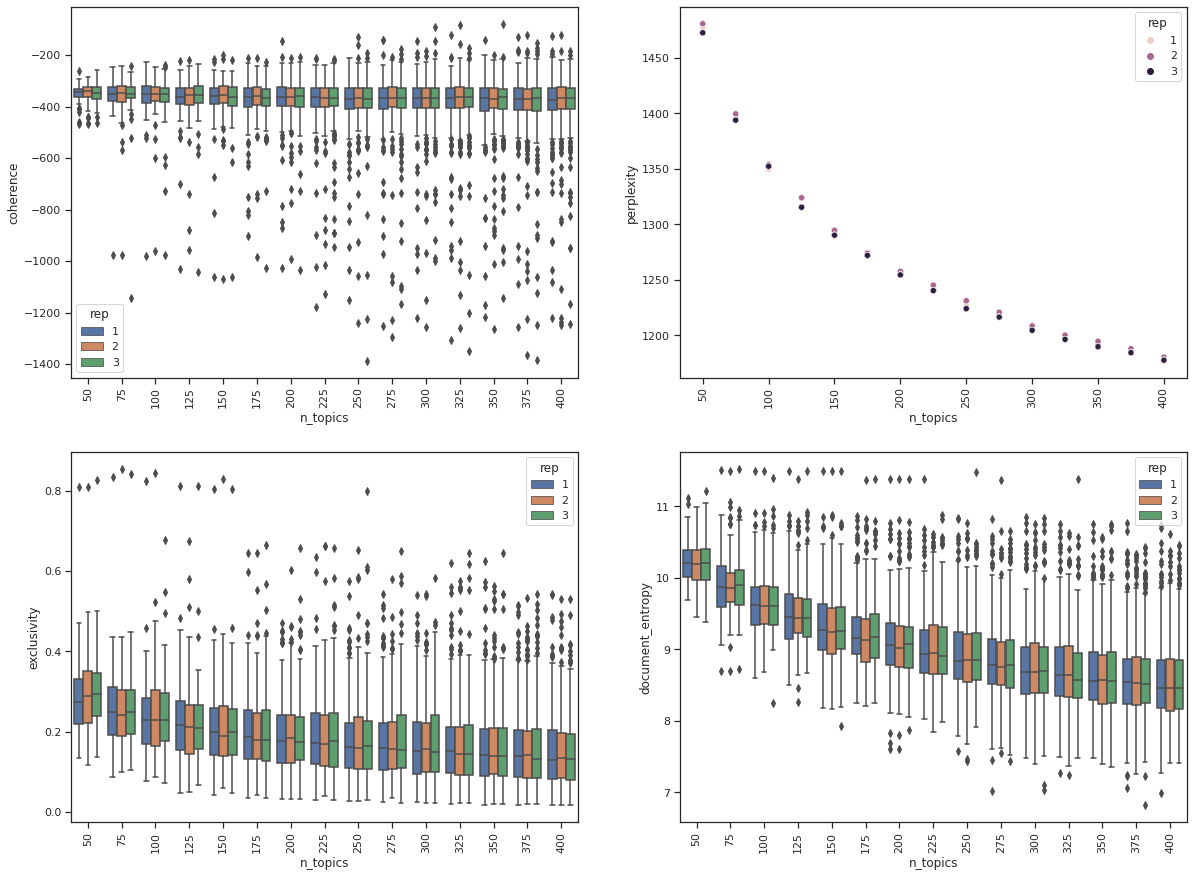

In [22]:
# plot settings
sns.set(rc={'figure.figsize':(20,15)}) 
sns.set_theme(style="ticks")
fig, axs = plt.subplots(ncols=2, nrows=2)

# turn dict into df
df = pd.DataFrame(data)

# Plot 
p = sns.boxplot(x="n_topics", y="coherence", hue = "rep",  data=df, ax = axs[0,0])
# p.axhline(-950, linestyle ="--")
p.tick_params(axis='x', labelrotation=90)
# p.axvspan(xmin=190, xmax=230, alpha=0.5)

p = sns.scatterplot(x="n_topics", y="perplexity", hue = "rep",  data=df, ax = axs[0,1])
p.tick_params(axis='x', labelrotation=90)

p = sns.boxplot(x="n_topics", y="exclusivity", hue = "rep",  data=df, ax = axs[1,0])
p.tick_params(axis='x', labelrotation=90)

p = sns.boxplot(x="n_topics", y="document_entropy", hue = "rep",  data=df, ax = axs[1,1])
p.tick_params(axis='x', labelrotation=90)


